# Imports

In [ ]:
import pandas as pd
from scipy.stats import shapiro, anderson, normaltest  # Using alternative tests
import numpy as np
from scipy.stats import zscore
import re
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Functions

In [ ]:
def standarize_cols(data):
    data.columns = data.columns.str.lower().str.strip()
    return data

In [ ]:
def standarize_sorted_data(data):
    # Define the new column names in the desired order
    new_column_names = [
        'no',
        'date',
        'time',
        'mag',
        'latitude',
        'longitude',
        'depth',
        'keterangan',
        'dirasakan',
        'sumber'
    ]

    # Check if the number of columns matches the expected number
    if len(data.columns) != len(new_column_names):
        raise ValueError(f"Expected {len(new_column_names)} columns, but got {len(data.columns)}")

    # Rename the columns in order
    data.columns = new_column_names

    dtype_mapping = {
        'no': 'Int64',                   # Use 'Int64' for nullable integers
        'date': 'datetime64[ns]',     # Datetime format
        'time': 'string',         # String type
        'mag': 'float64',                # Float type
        'latitude': 'float64',
        'longitude': 'float64',
        'depth': 'Int64',
        'keterangan': 'string',
        'dirasakan': 'string',
        'sumber': 'string'
    }

    # Step 3: Check for missing columns and add them if necessary
    expected_columns = list(dtype_mapping.keys())
    missing_columns = [col for col in expected_columns if col not in data.columns]
    if missing_columns:
        print(f"Warning: The following expected columns are missing and will be added with NaN values: {missing_columns}")
        for col in missing_columns:
            data[col] = pd.NA  # Adds missing columns with NaN values

    # Step 4: Convert data types
    for col, dtype in dtype_mapping.items():
        if col in data.columns:
            try:
                if dtype.startswith('datetime'):
                    # Convert to datetime, coerce errors to NaT
                    data[col] = pd.to_datetime(data[col], errors='coerce')
                else:
                    # For other types, use astype with errors='ignore' to prevent exceptions
                    data[col] = data[col].astype(dtype, errors='ignore')
            except Exception as e:
                print(f"Error converting column '{col}' to {dtype}: {e}")

    return data

In [ ]:
def rearrange_columns(data):
    """
    Re-arrange columns in the DataFrame to the specified order:
        - 'date'
        - 'time'
        - 'latitude'
        - 'longitude'
        - 'depth'
        - 'mag'
    """
    # Define the desired column order
    column_order = ['date', 'time', 'latitude', 'longitude', 'depth', 'mag']

    # Re-arrange the columns in the DataFrame
    data = data[column_order]

    return data

In [ ]:
def impute_missing_values(df):
    # Make a copy of the dataframe to avoid inplace issues
    df = df.copy()

    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Check if enough data is present for a normality test
        if df[column].dropna().shape[0] >= 3:
            # Use an alternative normality test suitable for larger datasets
            if df[column].dropna().shape[0] > 5000:
                stat, p_value = normaltest(df[column].dropna())
            else:
                stat, p_value = shapiro(df[column].dropna())

            # Impute based on normality
            if p_value > 0.05:  # Normal distribution
                impute_value = df[column].mean()
            else:  # Non-normal distribution
                impute_value = df[column].median()
        else:
            # If too few values, impute with a constant or other method as fallback
            impute_value = df[column].median()

        # Apply imputation without inplace=True to avoid the warning
        df[column] = df[column].fillna(impute_value)

    return df

In [ ]:
def standarize_data_types(data):
    dtype_mapping = {
        'date': 'datetime64[ns]',
        'time': 'string',
        'latitude': 'float64',
        'longitude': 'float64',
        'depth': 'float64',
        'mag': 'float64'
    }

    # Convert data types
    for col, dtype in dtype_mapping.items():
        if dtype == 'datetime64[ns]':
            # Convert to datetime, coerce errors to NaT
            data[col] = pd.to_datetime(data[col], errors='coerce')
        elif dtype == 'float64':
            # Convert to float, coerce errors to NaN
            data[col] = pd.to_numeric(data[col], errors='coerce')
            # print(f"[DEBUG] Column '{col}' converted to {dtype}")
        else:
            # For other types, use astype with errors='ignore'
            data[col] = data[col].astype(dtype, errors='ignore')
            # print(f"[DEBUG] Column '{col}' converted to {dtype}")

    return data

In [ ]:
lower_percentile = 0.01
upper_percentile = 0.99

# Method 1: Apply IQR-based capping
def iqr_outlier_capping(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Cap outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

# Method 2: Z-score capping for normal distribution
def zscore_outlier_capping(df, columns, threshold=3):
    for col in columns:
        df[col] = np.where(np.abs(zscore(df[col])) > threshold,
                           np.sign(zscore(df[col])) * threshold * df[col].std() + df[col].mean(),
                           df[col])
    return df

# Method 3: Percentile-based capping (best for skewed data)
def percentile_outlier_capping(df, columns, lower_p, upper_p):
    for col in columns:
        lower_bound = df[col].quantile(lower_p)
        upper_bound = df[col].quantile(upper_p)
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply a dynamic approach based on data distribution
def handle_outliers_dynamically(df, columns):
    for col in columns:
        # Check skewness and kurtosis to choose the method
        skewness = df[col].skew()
        kurtosis = df[col].kurt()

        if abs(skewness) < 1 and abs(kurtosis) < 3:  # Normal-like distribution
            print(f"Applying Z-score capping for {col} because:\n  -it has low skewness ({skewness:.2f})\n  -low kurtosis ({kurtosis:.2f})\n  indicating a roughly normal distribution.\n")
            df = zscore_outlier_capping(df, [col])

        elif abs(skewness) < 1:  # Mildly skewed but not normal
            print(f"Applying IQR capping for {col} because:\n  -it has low skewness ({skewness:.2f})\n  - high kurtosis ({kurtosis:.2f})\n  suggesting a distribution with long tails.\n")
            df = iqr_outlier_capping(df, [col])

        else:  # Highly skewed data
            print(f"Applying percentile capping for {col} because:\n  -it has high skewness ({skewness:.2f})\n  indicating a skewed distribution. Percentile capping is less sensitive to skewness.\n")
            df = percentile_outlier_capping(df, [col], lower_percentile, upper_percentile)

    return df


In [ ]:
def is_valid_time(time_str):
    for pattern in valid_time_patterns:
        if pattern.match(time_str):
            return True
    return False

# Code

## Load Datasets

In [ ]:
data_raw_1907_1999 = pd.read_excel("1907-2018.xlsx", sheet_name='1907-1999')
data_raw_2000_2008 = pd.read_excel("1907-2018.xlsx", sheet_name='2000-2008')
data_raw_2008_2017 = pd.read_excel("1907-2018.xlsx", sheet_name='2008-2017')

data_sorted_2019 =  pd.read_excel("Data Gempa 2019 - 2023.xlsx", sheet_name='2019')
data_sorted_2020 =  pd.read_excel("Data Gempa 2019 - 2023.xlsx", sheet_name='2020')
data_sorted_2021 =  pd.read_excel("Data Gempa 2019 - 2023.xlsx", sheet_name='2021')
data_sorted_2022 =  pd.read_excel("Data Gempa 2019 - 2023.xlsx", sheet_name='2022')
data_sorted_2023 =  pd.read_excel("Data Gempa 2019 - 2023.xlsx", sheet_name='2023')

## Initial Preprocessing

In [ ]:
dataframes = [
    data_raw_1907_1999,
    data_raw_2000_2008,
    data_raw_2008_2017,
    data_sorted_2019,
    data_sorted_2020,
    data_sorted_2021,
    data_sorted_2022,
    data_sorted_2023
]

for df in dataframes:
    standarize_cols(df)

In [ ]:
data_raw_2008_2017 = data_raw_2008_2017.drop(columns=['cphase', 'region'])
data_raw_2008_2017.rename(columns={'typemag': 'magtype'}, inplace=True)

In [ ]:
data_raw = pd.concat([data_raw_1907_1999, data_raw_2000_2008, data_raw_2008_2017], ignore_index=True)
data_raw = data_raw.drop(columns=['magtype'])

In [ ]:
data_sorted_2019 = data_sorted_2019.drop(columns=['unnamed: 5', 'unnamed: 7'])
data_sorted_2021 = data_sorted_2021.drop(columns=['jam', 'menit', 'detik', 's/n', 'e'])
data_sorted_2022 = data_sorted_2022.drop(columns=['jam', 'menit', 'detik', 's/n', 'e'])
data_sorted_2023 = data_sorted_2023.drop(columns=['jam', 'menit', 'detik', 'unnamed: 8', 'unnamed: 10'])

In [ ]:
dataframes = [
    data_sorted_2019,
    data_sorted_2020,
    data_sorted_2021,
    data_sorted_2022,
    data_sorted_2023
]

for df in dataframes:
    standarize_sorted_data(df)

In [ ]:
data_sorted = pd.concat([data_sorted_2019, data_sorted_2020, data_sorted_2021, data_sorted_2022, data_sorted_2023], ignore_index=True)
data_sorted = data_sorted.drop(columns=['no', 'keterangan', 'dirasakan', 'sumber'])

In [ ]:
data_raw = rearrange_columns(data_raw)
data_sorted = rearrange_columns(data_sorted)

## Concat data

merging data A (range 1907-2017) with data B (range 2019-2023)

In [ ]:
working_data = pd.concat([data_raw, data_sorted], ignore_index=True)
working_data = standarize_data_types(working_data)

In [ ]:
working_data.to_csv("Data Gempa 1907-2023.csv", index=False)

In [ ]:
working_data

,date,time,latitude,longitude,depth,mag
0,1907-01-04,05:19:11,1.873,94.209,15.0,7.8
1,1910-12-16,14:44:55,4.685,126.051,15.0,7.6
2,1911-08-16,22:41:17,7.237,136.944,15.0,7.8
3,1912-09-29,20:51:23,7.299,136.888,15.0,7.5
4,1913-03-14,08:45:04,5.354,126.121,15.0,7.8
...,...,...,...,...,...,...
105741,2023-05-30,18:21:09,3.530,118.820,7.0,2.1
105742,2023-05-30,19:42:23,2.420,121.170,3.0,1.8
105743,2023-05-30,20:48:12,2.440,120.970,5.0,2.1
105744,2023-05-31,02:46:08,1.620,120.220,4.0,2.5


## Checking & Handling Missing Values

In [ ]:
missing_columns = working_data.isnull().sum()
print("Missing Values:")
for column, missing_count in missing_columns[missing_columns > 0].items():
    if missing_count > 0:
        print(f"   - column: '{column}' has {missing_count} missing values")
    else:
        print(f"   - column: '{column}' has no missing values")

Missing Values:
   - column: 'date' has 22 missing values
   - column: 'time' has 5 missing values
   - column: 'latitude' has 14 missing values
   - column: 'longitude' has 20 missing values
   - column: 'depth' has 14 missing values
   - column: 'mag' has 9 missing values


In [ ]:
working_data = working_data.dropna(subset=['time', 'date'], how='any')

In [ ]:
working_data = impute_missing_values(working_data)
print("MIssing Values Handled!")

MIssing Values Handled!


In [ ]:
working_data.to_csv("Data Gempa 1907-2023 - CLEANED.csv", index=False)

In [ ]:
working_data['date'].min(),working_data['date'].max()

(Timestamp('1900-01-08 00:00:00'), Timestamp('2023-05-31 00:00:00'))

In [ ]:
working_data.shape

(105724, 6)

## Outlier Handling

In [ ]:
exclude_columns = ['date', 'time']
columns_to_check = [col for col in working_data.columns if col not in exclude_columns]

working_data = handle_outliers_dynamically(working_data, columns_to_check)

Applying Z-score capping for latitude because:
  -it has low skewness (0.04)
  -low kurtosis (-0.64)
  indicating a roughly normal distribution.

Applying percentile capping for longitude because:
  -it has high skewness (324.53)
  indicating a skewed distribution. Percentile capping is less sensitive to skewness.

Applying percentile capping for depth because:
  -it has high skewness (3.43)
  indicating a skewed distribution. Percentile capping is less sensitive to skewness.

Applying IQR capping for mag because:
  -it has low skewness (0.60)
  - high kurtosis (36.71)
  suggesting a distribution with long tails.



## Data Splitting

In [ ]:
working_data['time'] = working_data['time'].astype(str)

valid_time_patterns = [
    re.compile(r'^\d{1,2}:\d{2}:\d{2}\.\d+$'),  # Matches HH:MM:SS.microseconds
    re.compile(r'^\d{1,2}:\d{2}:\d{2}$'),       # Matches HH:MM:SS
]

working_data_cleaned = working_data[working_data['time'].apply(is_valid_time)].reset_index(drop=True)
working_data = working_data_cleaned

working_data['datetime_str'] = working_data['date'].astype(str) + ' ' + working_data['time']
working_data['datetime'] = pd.to_datetime(
    working_data['datetime_str'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce'
)

mask = working_data['datetime'].isnull()
if mask.any():
    working_data.loc[mask, 'datetime'] = pd.to_datetime(
        working_data.loc[mask, 'datetime_str'], format='%Y-%m-%d %H:%M:%S', errors='coerce'
    )

if working_data['datetime'].isnull().any():
    working_data = working_data[working_data['datetime'].notnull()].reset_index(drop=True)

working_data = working_data.drop(columns=['date', 'time', 'datetime_str'])
working_data = working_data.sort_values('datetime').reset_index(drop=True)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_records = len(working_data)
train_end_idx = int(total_records * train_ratio)
val_end_idx = int(total_records * (train_ratio + val_ratio))

train_data = working_data.iloc[:train_end_idx].reset_index(drop=True)
val_data = working_data.iloc[train_end_idx:val_end_idx].reset_index(drop=True)
test_data = working_data.iloc[val_end_idx:].reset_index(drop=True)

print(f"Training data range: {train_data['datetime'].min()} to {train_data['datetime'].max()}")
print(f"Validation data range: {val_data['datetime'].min()} to {val_data['datetime'].max()}")
print(f"Testing data range: {test_data['datetime'].min()} to {test_data['datetime'].max()}")

train_data = train_data.drop(columns=['datetime'])
val_data = val_data.drop(columns=['datetime'])
test_data = test_data.drop(columns=['datetime'])

Training data range: 1900-01-08 12:16:22 to 2014-04-09 19:43:31.500000
Validation data range: 2014-04-09 20:07:54.100000 to 2017-03-31 13:14:08.300000
Testing data range: 2017-03-31 13:59:18.300000 to 2023-05-31 15:43:34


## Data Encoding

In [ ]:
# Select features and target
features = ['latitude', 'longitude', 'depth', 'mag']
target_column = 'mag'

scaler = MinMaxScaler()
scaler.fit(train_data[features])

train_features = scaler.transform(train_data[features])
val_features = scaler.transform(val_data[features])
test_features = scaler.transform(test_data[features])

train_data_scaled = pd.DataFrame(train_features, columns=features)
val_data_scaled = pd.DataFrame(val_features, columns=features)
test_data_scaled = pd.DataFrame(test_features, columns=features)

train_data_scaled[target_column] = train_data[target_column].reset_index(drop=True)
val_data_scaled[target_column] = val_data[target_column].reset_index(drop=True)
test_data_scaled[target_column] = test_data[target_column].reset_index(drop=True)

In [ ]:
def create_sequences(data, seq_length, target_column):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length][features].values
        target = data.iloc[i+seq_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define sequence length
seq_length = 10  # Number of time steps to look back

# Prepare sequences
X_train, y_train = create_sequences(train_data_scaled, seq_length, target_column)
X_val, y_val = create_sequences(val_data_scaled, seq_length, target_column)
X_test, y_test = create_sequences(test_data_scaled, seq_length, target_column)

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (73951, 10, 4), y_train shape: (73951,)
X_val shape: (15839, 10, 4), y_val shape: (15839,)
X_test shape: (15839, 10, 4), y_test shape: (15839,)


## Model Building

#### Define the Model

In [ ]:
# Define the model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(seq_length, len(features))))
model.add(Dense(1))  # Predicting a single value (magnitude)

/Users/AndiZakyAshari/Documents/Internship/Projects/venv/py311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile the Model

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

#### Train the Model

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8302 - mae: 0.6036 - val_loss: 0.6240 - val_mae: 0.6443
Epoch 2/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3706 - mae: 0.4649 - val_loss: 0.6098 - val_mae: 0.6375
Epoch 3/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3683 - mae: 0.4624 - val_loss: 0.6264 - val_mae: 0.6457
Epoch 4/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3713 - mae: 0.4655 - val_loss: 0.6089 - val_mae: 0.6374
Epoch 5/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3660 - mae: 0.4605 - val_loss: 0.6910 - val_mae: 0.6764
Epoch 6/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3661 - mae: 0.4621 - val_loss: 0.6355 - val_mae: 0.6498
Epoch 7/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3652 - mae: 0.4608 - val_loss: 0.6123 - val_mae: 0.6394
Epoch 8/100
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3645 - mae: 0.4599 - val_loss: 0.6144 - val_mae: 0.6405
Epoch 9/100
2311/2311 ━━━━━━━━━━

#### Evaluate the Test Set

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.5674 - mae: 0.6080
Test Loss: 0.6014765501022339, Test MAE: 0.6316521763801575


#### Predict the Test Set

In [ ]:
y_pred = model.predict(X_test)
y_pred_flat = y_pred.flatten()


test_data = test_data.reset_index(drop=True)
test_data_adjusted = test_data.iloc[seq_length:].reset_index(drop=True)
test_data_adjusted['predicted mag'] = y_pred_flat

495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


In [ ]:
test_data_adjusted

,latitude,longitude,depth,mag,predicted mag
0,-0.18,123.29,11.0,3.0,3.684502
1,-0.22,122.44,30.0,2.9,3.673699
2,-9.03,124.04,103.0,4.4,3.560390
3,-8.17,107.58,53.0,4.1,3.717516
4,4.48,96.41,10.0,3.3,3.898545
...,...,...,...,...,...
15834,3.53,118.82,7.0,2.1,2.666555
15835,2.42,121.17,3.0,1.8,2.643843
15836,2.44,120.97,5.0,2.1,2.550112
15837,1.62,120.22,4.0,2.5,2.987360


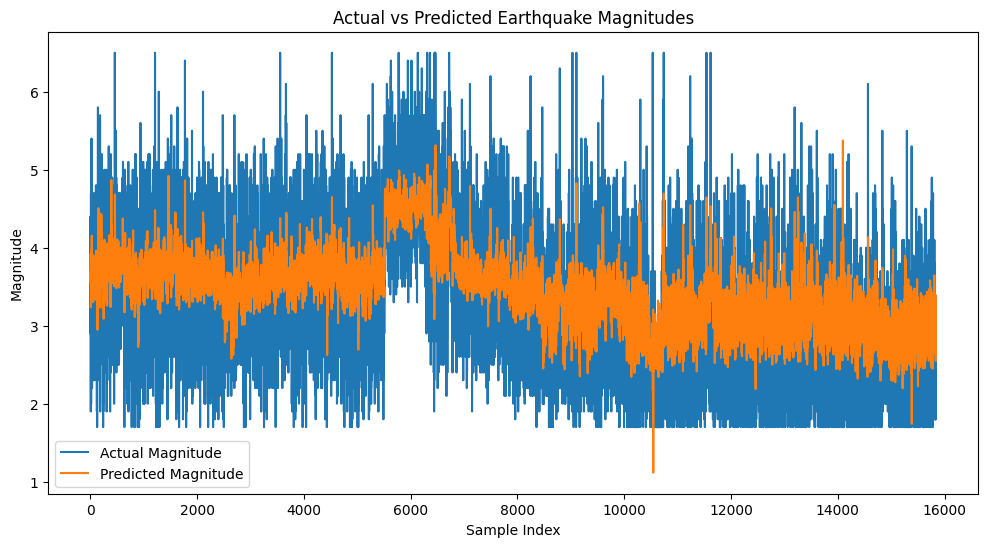

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual Magnitude')
plt.plot(y_pred_flat, label='Predicted Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitudes')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

**Observations**

1. **Predicted Values Range**:
   - The predicted values (orange line) appear to be clustered within a narrow range, mostly between magnitudes **3 and 4.5**.
   - This range suggests that the model is not capturing the full variability of the actual magnitudes, especially when they fall outside this range.

2. **Actual Values Range**:
   - The actual magnitudes (blue line) display a wide range of values, including multiple spikes reaching up to around magnitude **6** and dips below **2**.
   - There is substantial variability in the actual magnitudes, with frequent peaks and valleys, indicating natural fluctuations in earthquake intensities.

3. **Underestimation and Overestimation**:
   - For higher actual magnitudes (above ~4.5), the model consistently underestimates, rarely predicting values above this threshold.
   - Similarly, when the actual magnitudes dip below ~3, the model often overestimates, as the predictions remain within a limited range.
   
4. **Limited Dynamic Response**:
   - The model shows a relatively "flat" or "smoothed" prediction pattern, meaning it does not dynamically respond to the rapid changes in magnitude.
   - This flatness may indicate that the model struggles to capture the temporal dependencies or the sudden shifts characteristic of seismic events.

**Potential Issues and Root Causes**

1. **High Bias / Underfitting**:
   - The model appears to be underfitting, which can occur when the model's capacity is insufficient to learn the complexity in the data.
   - This might be due to insufficient layers or units in the LSTM or inadequate sequence length to capture the temporal dependencies of earthquake data.

2. **Lack of Predictive Features**:
   - Earthquake magnitudes are influenced by numerous factors beyond the included features (latitude, longitude, depth).
   - Additional geophysical and historical features could help the model better capture the fluctuations in earthquake magnitudes.

3. **Possible Data Imbalance**:
   - If the dataset contains a high proportion of magnitudes within a narrow range (e.g., between 3 and 4), the model might be biased towards predicting values in this range.

4. **Difficulty in Learning Spikes**:
   - Earthquake data often include sharp spikes or sudden changes, which are hard for LSTM models to learn if they are infrequent or if the model's capacity is limited.

**Recommendations for Improvement**

1. **Enhance the Model Architecture**:
   - Increase the complexity of the model by adding more LSTM layers or using more units per layer.
   - Experiment with **stacked LSTMs** or **Bidirectional LSTMs**, which may improve the model’s ability to capture dependencies in both directions of the sequence.

2. **Feature Engineering**:
   - Incorporate more features, such as historical earthquake patterns, tectonic plate interactions, or seismic stress indicators.
   - Adding temporal features, like the time since the last earthquake, might help capture cyclical patterns.

3. **Adjust Sequence Length**:
   - Increase the sequence length (currently set at 10) to allow the model to learn longer dependencies.
   - Earthquake data often have complex dependencies over time, and a longer sequence may help the model detect these.

4. **Consider Ensemble Models**:
   - Combine the LSTM model with other machine learning models (e.g., XGBoost) to create an ensemble that might capture different patterns in the data.
   - Ensemble models are sometimes more robust to variability in time series data.

5. **Use Data Balancing Techniques**:
   - If the dataset is skewed toward certain magnitude ranges, try oversampling or undersampling techniques to balance the data.
   - Techniques like **SMOTE** could help the model learn more effectively across the entire range of magnitudes.

**Conclusion**

The plot indicates that the model currently lacks the ability to capture the full range and variability of earthquake magnitudes, likely due to high bias (underfitting). Enhancing the model's architecture, adding relevant features, and fine-tuning the sequence length could improve performance. The recommendations provided aim to address these challenges and may help create a model that better predicts the fluctuations observed in actual earthquake magnitudes.

#### Analyze Model Performance

In [ ]:
# Calculate R-squared
r2 = r2_score(y_test_flat, y_pred_flat)
print(f'R-squared Score: {r2}')

R-squared Score: 0.2591125034189502


**Model Evaluation Metrics**

**1. R-squared Score**

```plaintext
R-squared Score: 0.2591125034189502
```

**Interpretation:**

- **R-squared**, also known as the coefficient of determination, measures the proportion of variance in the dependent variable (earthquake magnitudes) that is predictable from the independent variables (latitude, longitude, depth).
- **Value Range:** Ranges from 0 to 1.
  - **0** indicates that the model explains none of the variability of the target data.
  - **1** indicates that the model explains all the variability of the target data.
- **Your Result:** An R-squared of approximately **0.259** means that **25.9%** of the variance in earthquake magnitudes is explained by your model.
  - **Implication:** The model captures some patterns but leaves a significant portion (74.1%) of the variance unexplained.

#### **2. Test Loss and Test MAE**

```plaintext
Test Loss: 0.6014765501022339
Test MAE: 0.6316521763801575
```

**Interpretation:**

- **Test Loss (Mean Squared Error):**
  - Measures the average squared difference between predicted and actual magnitudes.
  - A lower value indicates better model performance.
- **Test MAE (Mean Absolute Error):**
  - Represents the average absolute difference between predicted and actual magnitudes.
  - **Your Result:** An MAE of **0.6317** suggests that, on average, your model's predictions are off by **±0.63 magnitude units**.
  - **Magnitude Scale Context:**
    - Earthquake magnitudes typically range from 0 to 10 on the Richter scale, with most being less than 5.
    - An error of 0.63 can be significant, especially for smaller magnitude earthquakes.

---

### **Insights and Conclusions**

#### **1. Model Performance Overview**

- **Partial Predictive Capability:**
  - The model has learned some underlying patterns, as indicated by the R-squared value being greater than zero.
- **Significant Unexplained Variance:**
  - A large portion of variance in earthquake magnitudes remains unexplained, indicating potential shortcomings in the model or data.
- **Prediction Error:**
  - The MAE of 0.63 suggests moderate accuracy but may not be sufficient for precise earthquake magnitude predictions.

#### **2. Possible Reasons for the Observed Performance**

**a. Limited Features:**

- **Key Geophysical Factors Missing:**
  - Earthquake magnitudes are influenced by complex geological and physical processes.
  - Features like **tectonic plate interactions**, **historical seismic activity**, **fault line characteristics**, and **geological compositions** are critical.
- **Current Features:**
  - Using only **latitude**, **longitude**, and **depth** may not capture the full complexity required to predict magnitudes accurately.

**b. Data Quality and Quantity:**

- **Noise and Variability:**
  - Earthquake data can be highly variable and noisy, making it challenging for models to learn accurate patterns.
- **Imbalanced Data:**
  - If the dataset contains mostly small magnitude earthquakes, the model may struggle with predicting larger magnitudes.

**c. Model Architecture:**

- **Model Complexity:**
  - A single-layer LSTM with 64 units might be insufficient to model the complex relationships.
- **Sequence Length:**
  - The chosen sequence length (`seq_length = 10`) might not capture long-term dependencies in the data.

**d. Overfitting or Underfitting:**

- **Underfitting:**
  - The model might be too simple to capture the underlying patterns.
- **Overfitting:**
  - Alternatively, the model might not generalize well to unseen data if it overfits the training data.

#### **3. Recommendations for Improvement**

**a. Enhance Feature Set:**

- **Incorporate Additional Features:**
  - **Temporal Features:** Time since the last earthquake, seasonality effects, time of day.
  - **Geophysical Data:** Rock types, soil compositions, tectonic plate boundaries, stress accumulation data.
  - **Seismic Indicators:** Historical seismic activity, energy release patterns.
- **External Data Sources:**
  - Integrate data from geological surveys, satellite imagery, or other relevant sources.

**b. Data Preprocessing:**

- **Feature Engineering:**
  - Create new features by combining existing ones or calculating statistical measures (e.g., moving averages).
- **Handle Outliers:**
  - Identify and treat outliers that may skew the model's learning process.
- **Normalization:**
  - Ensure all features, including the target variable if necessary, are appropriately scaled.

**c. Model Architecture and Training:**

- **Increase Model Complexity:**
  - Add more LSTM layers or units to capture complex patterns.
  - Experiment with bidirectional LSTMs or stacked LSTMs.
- **Regularization Techniques:**
  - Apply dropout layers to prevent overfitting.
- **Hyperparameter Tuning:**
  - Experiment with different learning rates, batch sizes, activation functions, and optimizers.
- **Sequence Length Adjustment:**
  - Try longer sequence lengths to capture more temporal dependencies.

**d. Alternative Modeling Approaches:**

- **Other Neural Network Architectures:**
  - Explore Convolutional Neural Networks (CNNs) for pattern recognition in the data.
  - Consider Transformer models, which have shown success in time-series prediction.
- **Traditional Machine Learning Models:**
  - Test models like Random Forests, Gradient Boosting Machines, or Support Vector Regressors.
- **Ensemble Methods:**
  - Combine predictions from multiple models to improve overall performance.

**e. Cross-Validation and Evaluation:**

- **K-Fold Cross-Validation:**
  - Use cross-validation to assess model performance more robustly.
- **Evaluation Metrics:**
  - Examine additional metrics like Root Mean Squared Error (RMSE) or Mean Absolute Percentage Error (MAPE).

**f. Domain Expertise:**

- **Collaborate with Seismologists:**
  - Gain insights into which factors are most predictive of earthquake magnitudes.
- **Geospatial Analysis:**
  - Use spatial statistics to understand regional variations.

---

### **Conclusion**

Your model demonstrates some predictive capability but is currently limited in its ability to accurately predict earthquake magnitudes. The low R-squared value indicates that significant variability in the data remains unexplained. This outcome is not unexpected given the complexity of earthquake phenomena and the limited feature set.

**Key Takeaways:**

- **Complexity of Earthquake Prediction:**
  - Earthquake magnitudes are influenced by numerous, complex factors that are challenging to model.
- **Need for Enhanced Features:**
  - Incorporating more relevant and diverse features is crucial for improving model performance.
- **Model Refinement:**
  - Adjusting the model architecture and parameters can lead to better results.
- **Realistic Expectations:**
  - Predicting earthquakes is inherently difficult, and even advanced models may have limitations.

**Next Steps:**

1. **Feature Expansion:**
   - Collect and integrate additional data sources.
2. **Model Experimentation:**
   - Try different models and architectures.
3. **Data Analysis:**
   - Perform exploratory data analysis to uncover hidden patterns.
4. **Consult Domain Experts:**
   - Leverage expertise in seismology to guide your modeling efforts.
5. **Iterative Improvement:**
   - Continuously test and refine your model based on feedback and results.
